In [18]:
import numpy as np


def loss(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)

def loss_d(y_true, y_pred):
    return 2 * y_pred - 2 * y_true

def abs_loss(y_true, y_pred):
    return  np.sum(abs(y_true - y_pred))

def abs_loss_d(y_true, y_pred):
    return -np.sign(y_true - y_pred)

def sigm_fun(x):
    return 1 / (1 + np.exp(-x))


def sigm_d(sigm_val):
    return sigm_val * (1 - sigm_val)


def relu(x):
    return 0 if x < 0 else x


def relu_d(relu_val):
    return 0 if relu_val <= 0 else 1


def softmax(outputs):
    exp_outputs = [math.exp(o) for o in outputs]
    total = sum(exp_outputs)
    return [eo / total for eo in exp_outputs]


def cross_entropy_loss(y_true, y_pred):
    y_true = int(y_true - 1)
    return -(
        y_true * np.log(y_pred + 1e-10) + (1 - y_true) * np.log(1 - y_pred + 1e-10)
    )

def cross_entropy_loss_d(y_true, y_pred):
    y_true = int(y_true - 1)
    return y_pred - y_true

def Hinge_loss(y_true, y_pred):
    y_pred = 2*y_pred - 1 #Bo od -1 do 1
    y_true =  2*y_pred - 3 
    return max(0, 1 - y_true * y_pred)

def Hinge_loss_d(y_true, y_pred):
    y_pred = 2*y_pred - 1 #Bo od -1 do 1
    y_true =  2*y_pred - 3 
    if y_true * y_pred >= 1:
        return 0
    return -y_true

class Neuron:
    def __init__(self, rng, input_dim, activation_f, activation_f_d):
        self.activation_f = activation_f
        self.activation_f_d = activation_f_d
        weight_list = []
        for i in range(input_dim):
            weight_list.append(rng.uniform(-1, 1))
        self.weights = np.asarray(weight_list)
        self.b = rng.uniform(-1, 1)
        self.b_grad = 0
        self.w_grad = np.zeros(input_dim)
        self.out_grad = 0

    def work(self, inputs):
        self.x = np.array(inputs)
        sum = np.sum(inputs * self.weights) + self.b

        self.output = self.activation_f(sum)
        return self.output

    def x_grad(self, i):
        return self.out_grad * self.activation_f_d(self.output) * self.weights[i]

    def generate_param_grad(self):
        self.w_grad = self.out_grad * self.activation_f_d(self.output) * self.x
        self.b_grad = self.out_grad * self.activation_f_d(self.output)

    def update_weights(self, errors, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * errors[i] * self.x[i]


class NeuralNet:
    def __init__(
        self,
        number_of_neurons_in_layer,
        hidden_layers,
        input_dim,
        number_of_outputs=1,
        seed=10,
        activation_f="sigmoid",
    ):
        if activation_f == "sigmoid":
            act_f = sigm_fun
            act_f_d = sigm_d
        elif activation_f == "relu":
            act_f = relu
            act_f_d = relu_d
        else:
            print("Allowed activation_function values are {'sigmoid', 'relu'}")
            return

        self.rng = np.random.default_rng(seed)
        self.layers = []
        self.neurons: list[Neuron] = []
        layer_1 = [
            Neuron(self.rng, input_dim, act_f, act_f_d)
            for _ in range(number_of_neurons_in_layer)
        ]
        self.layers.append(layer_1)
        self.neurons.extend(layer_1)
        for i in range(hidden_layers - 1):
            current_layer = [
                Neuron(self.rng, number_of_neurons_in_layer, act_f, act_f_d)
                for _ in range(number_of_neurons_in_layer)
            ]
            self.neurons.extend(current_layer)
            self.layers.append(current_layer)
        output_layer = []
        for i in range(number_of_outputs):
            output_neuron = Neuron(
                self.rng,
                number_of_neurons_in_layer,
                activation_f=lambda x: x,
                activation_f_d=lambda x: 1,
            )
            output_layer.append(output_neuron)
            self.neurons.append(output_neuron)
        self.layers.append(output_layer)

    def predict_regre(self, inputs):
        outputs = inputs.copy()
        for layer in self.layers:
            outputs = [neuron.work(outputs) for neuron in layer]
        return outputs[0]

    def predict_class(self, inputs):
        outputs = inputs.copy()
        for layer in self.layers:
            outputs = [neuron.work(outputs) for neuron in layer]
        probabilitie = sigm_fun(outputs[0])

        return probabilitie

    def backprop_single_input(self, input, expected_value, error_measure_type = 1):
        y_pred = self.predict_regre(input)
        if(error_measure_type == 1):
            error = loss(expected_value, y_pred)
            error_d = loss_d(y_pred=y_pred, y_true=expected_value)
        else:
            error = abs_loss(expected_value, y_pred)
            error_d = abs_loss_d(y_pred=y_pred, y_true=expected_value)
        output_neuron = self.layers[-1][0]
        output_neuron.out_grad = error_d
        output_neuron.generate_param_grad()
        next_layer = self.layers[-1]
        for layer in reversed(self.layers[:-1]):
            for i, neuron in enumerate(layer):
                neuron.w_grad = 0
                neuron.out_grad = 0
                neuron.b_grad = 0
                for next_neuron in next_layer:
                    neuron.out_grad += next_neuron.x_grad(i)
                neuron.generate_param_grad()
        return error

    def train_regre(
        self, X, Y, learning_rate=0.05, epochs=50, print_logs=False, batch_size=50, error_measure_type = 1):
        n = min(batch_size, len(X))
        for k in range(epochs):
            tot_error = 0
            tot_grad = [(0, 0) for neuron in self.neurons]
            batch_ind = self.rng.integers(low=0, high=len(X), size=n)
            for x, y in zip(X[batch_ind], Y[batch_ind]):
                tot_error += self.backprop_single_input(x, y, error_measure_type)
                tot_grad = [
                    (grad[0] + neuron.w_grad, grad[1] + neuron.b_grad)
                    for grad, neuron in zip(tot_grad, self.neurons)
                ]
            tot_error = tot_error / n
            for grad, neuron in zip(tot_grad, self.neurons):
                neuron.weights -= grad[0] / n * learning_rate
                neuron.b -= grad[1] / n * learning_rate
            if print_logs:
                print(f"Epoch: {k}, mean loss: {tot_error}")

    def backprop_binary_input(self, input, expected_value,  error_measure_type = 1):
        y_pred = self.predict_class(input)
        if error_measure_type == 1:
            error = cross_entropy_loss(expected_value, y_pred)
            error_d = cross_entropy_loss_d(y_pred=y_pred, y_true=expected_value)
        elif error_measure_type == 2:
            error = Hinge_loss(expected_value, y_pred)
            error_d =Hinge_loss_d(y_pred=y_pred, y_true=expected_value)
        output_neuron = self.layers[-1][0]
        output_neuron.out_grad = error_d
        output_neuron.generate_param_grad()
        next_layer = self.layers[-1]
        for layer in reversed(self.layers[:-1]):
            for i, neuron in enumerate(layer):
                neuron.w_grad = 0
                neuron.out_grad = 0
                neuron.b_grad = 0
                for next_neuron in next_layer:
                    neuron.out_grad += next_neuron.x_grad(i)
                neuron.generate_param_grad()
        return error

    def train_class(
        self, X, Y, learning_rate=0.05, epochs=50, print_logs=False, batch_size=50, error_measure_type = 1
    ):
        n = min(batch_size, len(X))
        for k in range(epochs):
            tot_error = 0
            tot_grad = [(0, 0) for neuron in self.neurons]
            batch_ind = self.rng.integers(low=0, high=len(X), size=n)
            for x, y in zip(X[batch_ind], Y[batch_ind]):
                tot_error += self.backprop_binary_input(x, y, error_measure_type)
                tot_grad = [
                    (grad[0] + neuron.w_grad, grad[1] + neuron.b_grad)
                    for grad, neuron in zip(tot_grad, self.neurons)
                ]
            tot_error = tot_error / n
            for grad, neuron in zip(tot_grad, self.neurons):
                neuron.weights -= grad[0] / n * learning_rate
                neuron.b -= grad[1] / n * learning_rate
            if print_logs:
                print(f"Epoch: {k}, mean loss: {tot_error}")

In [5]:
import math

def evaluate_model_regre(model, X, Y):
    Y_pred = [model.predict_regre(x) for x in X]
    MSE = sum([(y_pred - y)**2 for y_pred, y in zip(Y_pred,Y)]) / len(Y)
    return math.sqrt(MSE)


def evaluate_model_class(model, X, Y):
    Y_pred = [model.predict_regre(x)  for x in X]
    MSE = sum([(y_pred - y-1)**2 for y_pred, y in zip(Y_pred,Y)]) / len(Y)
    return math.sqrt(MSE)

In [6]:
def scale(X, min, max):
    return (X.astype(float) - min) / (max - min)

In [7]:
def rescale(x, min, max):
    return x * (max - min) + min

In [35]:
train_data = np.genfromtxt('./projekt1/regression/data.activation.train.1000.csv', delimiter=',')
test_data = np.genfromtxt('./projekt1/regression/data.activation.test.1000.csv', delimiter=',')
X_train = train_data[1:, 0]
Y_train = train_data[1:, 1]
X_test = test_data[1:, 0]
Y_test = test_data[1:, 1]

net = NeuralNet(hidden_layers=3,number_of_neurons_in_layer=30,input_dim=1, activation_f='relu')
net.train_regre(X_train, Y_train, learning_rate=0.01, epochs=1000, print_logs=True)

print(f"RMSE on train data {evaluate_model_regre(net, X_train, Y_train)}")
print(f"RMSE on test data {evaluate_model_regre(net, X_test, Y_test)}")

Epoch: 0, mean loss: 11433.725791751858
Epoch: 1, mean loss: 40547.210398448355
Epoch: 2, mean loss: 1162268615507217.5
Epoch: 3, mean loss: 2.736413135979766e+79


C:\Users\Staś\AppData\Local\Temp\ipykernel_8356\3815465311.py:5: RuntimeWarning: overflow encountered in double_scalars
  return np.sum((y_true - y_pred) ** 2)
C:\Users\Staś\AppData\Local\Temp\ipykernel_8356\3815465311.py:84: RuntimeWarning: overflow encountered in multiply
  self.w_grad = self.out_grad * self.activation_f_d(self.output) * self.x
C:\Users\Staś\AppData\Local\Temp\ipykernel_8356\3815465311.py:75: RuntimeWarning: overflow encountered in multiply
  sum = np.sum(inputs * self.weights) + self.b
C:\Users\Staś\AppData\Local\Temp\ipykernel_8356\3815465311.py:75: RuntimeWarning: invalid value encountered in multiply
  sum = np.sum(inputs * self.weights) + self.b
C:\ProgramData\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.red

Epoch: 4, mean loss: inf
Epoch: 5, mean loss: nan
Epoch: 6, mean loss: nan
Epoch: 7, mean loss: nan
Epoch: 8, mean loss: nan
Epoch: 9, mean loss: nan
Epoch: 10, mean loss: nan
Epoch: 11, mean loss: nan
Epoch: 12, mean loss: nan
Epoch: 13, mean loss: nan
Epoch: 14, mean loss: nan
Epoch: 15, mean loss: nan
Epoch: 16, mean loss: nan
Epoch: 17, mean loss: nan
Epoch: 18, mean loss: nan
Epoch: 19, mean loss: nan
Epoch: 20, mean loss: nan
Epoch: 21, mean loss: nan
Epoch: 22, mean loss: nan
Epoch: 23, mean loss: nan
Epoch: 24, mean loss: nan
Epoch: 25, mean loss: nan
Epoch: 26, mean loss: nan
Epoch: 27, mean loss: nan
Epoch: 28, mean loss: nan
Epoch: 29, mean loss: nan
Epoch: 30, mean loss: nan
Epoch: 31, mean loss: nan
Epoch: 32, mean loss: nan
Epoch: 33, mean loss: nan
Epoch: 34, mean loss: nan
Epoch: 35, mean loss: nan
Epoch: 36, mean loss: nan
Epoch: 37, mean loss: nan
Epoch: 38, mean loss: nan
Epoch: 39, mean loss: nan
Epoch: 40, mean loss: nan
Epoch: 41, mean loss: nan
Epoch: 42, mean lo

Epoch: 313, mean loss: nan
Epoch: 314, mean loss: nan
Epoch: 315, mean loss: nan
Epoch: 316, mean loss: nan
Epoch: 317, mean loss: nan
Epoch: 318, mean loss: nan
Epoch: 319, mean loss: nan
Epoch: 320, mean loss: nan
Epoch: 321, mean loss: nan
Epoch: 322, mean loss: nan
Epoch: 323, mean loss: nan
Epoch: 324, mean loss: nan
Epoch: 325, mean loss: nan
Epoch: 326, mean loss: nan
Epoch: 327, mean loss: nan
Epoch: 328, mean loss: nan
Epoch: 329, mean loss: nan
Epoch: 330, mean loss: nan
Epoch: 331, mean loss: nan
Epoch: 332, mean loss: nan
Epoch: 333, mean loss: nan
Epoch: 334, mean loss: nan
Epoch: 335, mean loss: nan
Epoch: 336, mean loss: nan
Epoch: 337, mean loss: nan
Epoch: 338, mean loss: nan
Epoch: 339, mean loss: nan
Epoch: 340, mean loss: nan
Epoch: 341, mean loss: nan
Epoch: 342, mean loss: nan
Epoch: 343, mean loss: nan
Epoch: 344, mean loss: nan
Epoch: 345, mean loss: nan
Epoch: 346, mean loss: nan
Epoch: 347, mean loss: nan
Epoch: 348, mean loss: nan
Epoch: 349, mean loss: nan
E

Epoch: 620, mean loss: nan
Epoch: 621, mean loss: nan
Epoch: 622, mean loss: nan
Epoch: 623, mean loss: nan
Epoch: 624, mean loss: nan
Epoch: 625, mean loss: nan
Epoch: 626, mean loss: nan
Epoch: 627, mean loss: nan
Epoch: 628, mean loss: nan
Epoch: 629, mean loss: nan
Epoch: 630, mean loss: nan
Epoch: 631, mean loss: nan
Epoch: 632, mean loss: nan
Epoch: 633, mean loss: nan
Epoch: 634, mean loss: nan
Epoch: 635, mean loss: nan
Epoch: 636, mean loss: nan
Epoch: 637, mean loss: nan
Epoch: 638, mean loss: nan
Epoch: 639, mean loss: nan
Epoch: 640, mean loss: nan
Epoch: 641, mean loss: nan
Epoch: 642, mean loss: nan
Epoch: 643, mean loss: nan
Epoch: 644, mean loss: nan
Epoch: 645, mean loss: nan
Epoch: 646, mean loss: nan
Epoch: 647, mean loss: nan
Epoch: 648, mean loss: nan
Epoch: 649, mean loss: nan
Epoch: 650, mean loss: nan
Epoch: 651, mean loss: nan
Epoch: 652, mean loss: nan
Epoch: 653, mean loss: nan
Epoch: 654, mean loss: nan
Epoch: 655, mean loss: nan
Epoch: 656, mean loss: nan
E

Epoch: 925, mean loss: nan
Epoch: 926, mean loss: nan
Epoch: 927, mean loss: nan
Epoch: 928, mean loss: nan
Epoch: 929, mean loss: nan
Epoch: 930, mean loss: nan
Epoch: 931, mean loss: nan
Epoch: 932, mean loss: nan
Epoch: 933, mean loss: nan
Epoch: 934, mean loss: nan
Epoch: 935, mean loss: nan
Epoch: 936, mean loss: nan
Epoch: 937, mean loss: nan
Epoch: 938, mean loss: nan
Epoch: 939, mean loss: nan
Epoch: 940, mean loss: nan
Epoch: 941, mean loss: nan
Epoch: 942, mean loss: nan
Epoch: 943, mean loss: nan
Epoch: 944, mean loss: nan
Epoch: 945, mean loss: nan
Epoch: 946, mean loss: nan
Epoch: 947, mean loss: nan
Epoch: 948, mean loss: nan
Epoch: 949, mean loss: nan
Epoch: 950, mean loss: nan
Epoch: 951, mean loss: nan
Epoch: 952, mean loss: nan
Epoch: 953, mean loss: nan
Epoch: 954, mean loss: nan
Epoch: 955, mean loss: nan
Epoch: 956, mean loss: nan
Epoch: 957, mean loss: nan
Epoch: 958, mean loss: nan
Epoch: 959, mean loss: nan
Epoch: 960, mean loss: nan
Epoch: 961, mean loss: nan
E

In [36]:
train_data = np.genfromtxt(
    "./projekt1/regression/data.activation.train.1000.csv", delimiter=","
)
test_data = np.genfromtxt(
    "./projekt1/regression/data.activation.test.1000.csv", delimiter=","
)
X_train = train_data[1:, 0]
Y_train = train_data[1:, 1]
X_test = test_data[1:, 0]
Y_test = test_data[1:, 1]
minx = min(X_train)
maxx = max(X_train)

net = NeuralNet(
    hidden_layers=3, number_of_neurons_in_layer=30, input_dim=1, activation_f="relu"
)
X_scaled = scale(X_train, minx, maxx)
X_test_scaled = scale(X_test, minx, maxx)
net.train_regre(X_scaled, Y_train, learning_rate=0.0001, epochs=500, print_logs=True)

print(f"RMSE on train data {evaluate_model_regre(net, X_scaled, Y_train)}")
print(f"RMSE on test data {evaluate_model_regre(net, X_test_scaled, Y_test)}")

Epoch: 0, mean loss: 11306.865320462282
Epoch: 1, mean loss: 14148.753410118929
Epoch: 2, mean loss: 13599.151215362384
Epoch: 3, mean loss: 15893.00702725912
Epoch: 4, mean loss: 15437.430167388753
Epoch: 5, mean loss: 14257.950716308493
Epoch: 6, mean loss: 15131.613700341164
Epoch: 7, mean loss: 11664.606199259455
Epoch: 8, mean loss: 9140.047816139479
Epoch: 9, mean loss: 12667.906000550143
Epoch: 10, mean loss: 10504.252979932031
Epoch: 11, mean loss: 8707.162322085314
Epoch: 12, mean loss: 6366.6420711997
Epoch: 13, mean loss: 9226.832616495543
Epoch: 14, mean loss: 8183.194054233859
Epoch: 15, mean loss: 8375.539515230163
Epoch: 16, mean loss: 8573.122013976381
Epoch: 17, mean loss: 8914.353601866042
Epoch: 18, mean loss: 5831.123501319749
Epoch: 19, mean loss: 7824.544288556477
Epoch: 20, mean loss: 5184.837978393996
Epoch: 21, mean loss: 8147.191055044923
Epoch: 22, mean loss: 7233.398061234035
Epoch: 23, mean loss: 7244.434480805752
Epoch: 24, mean loss: 7975.948901783312
Epo

Epoch: 204, mean loss: 41.40269463091482
Epoch: 205, mean loss: 40.332062440864576
Epoch: 206, mean loss: 49.441352651480585
Epoch: 207, mean loss: 45.425139881004114
Epoch: 208, mean loss: 49.606515029497274
Epoch: 209, mean loss: 35.08500626605868
Epoch: 210, mean loss: 32.90135888051619
Epoch: 211, mean loss: 37.75774792559948
Epoch: 212, mean loss: 41.969359154011364
Epoch: 213, mean loss: 35.845194816815244
Epoch: 214, mean loss: 32.737458856998416
Epoch: 215, mean loss: 37.201089598281584
Epoch: 216, mean loss: 39.88176316941077
Epoch: 217, mean loss: 35.38145423630201
Epoch: 218, mean loss: 33.2398028069398
Epoch: 219, mean loss: 32.327583457079
Epoch: 220, mean loss: 32.18969614190553
Epoch: 221, mean loss: 28.547901482925752
Epoch: 222, mean loss: 26.892549554410007
Epoch: 223, mean loss: 29.078331311432493
Epoch: 224, mean loss: 39.23387984156891
Epoch: 225, mean loss: 24.198410837951222
Epoch: 226, mean loss: 43.73920572680702
Epoch: 227, mean loss: 29.68511624584655
Epoch: 

Epoch: 403, mean loss: 14.496304400105057
Epoch: 404, mean loss: 14.691667910110716
Epoch: 405, mean loss: 16.176915414772353
Epoch: 406, mean loss: 17.996963325914177
Epoch: 407, mean loss: 16.000548562937933
Epoch: 408, mean loss: 13.986381020506858
Epoch: 409, mean loss: 16.32990010394565
Epoch: 410, mean loss: 13.8791175242486
Epoch: 411, mean loss: 12.638429815072591
Epoch: 412, mean loss: 13.089951136676804
Epoch: 413, mean loss: 15.858725440615094
Epoch: 414, mean loss: 13.785830353841384
Epoch: 415, mean loss: 13.674428974977795
Epoch: 416, mean loss: 15.845390515960148
Epoch: 417, mean loss: 12.899819145767403
Epoch: 418, mean loss: 15.282425295845613
Epoch: 419, mean loss: 18.109236673046773
Epoch: 420, mean loss: 20.078482610736145
Epoch: 421, mean loss: 15.137511731720549
Epoch: 422, mean loss: 14.146102343431
Epoch: 423, mean loss: 18.26477277224099
Epoch: 424, mean loss: 14.009888555575124
Epoch: 425, mean loss: 12.559727336939863
Epoch: 426, mean loss: 14.22630670521865


Plot scaled

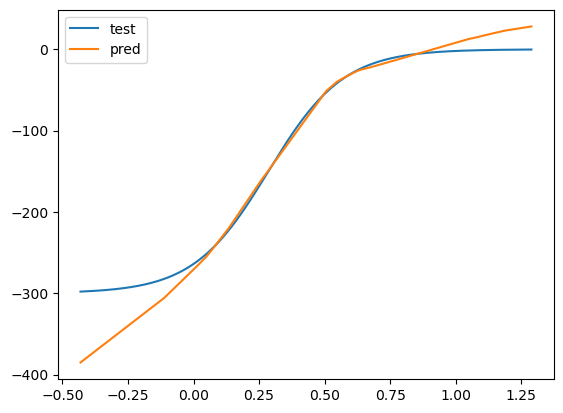

In [37]:

import matplotlib.pyplot as plt
ind = np.argsort(X_test_scaled)
plt.plot(X_test_scaled, Y_test, label = 'test')
Y_pred = [net.predict_regre(x) for x in X_test_scaled]
plt.plot(X_test_scaled, Y_pred, label = 'pred')
plt.legend()

Plot not scaled


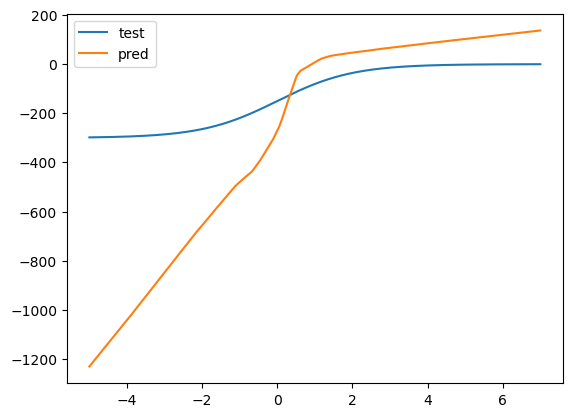

In [38]:
import matplotlib.pyplot as plt
ind = np.argsort(X_train)
plt.plot(X_test, Y_test, label = 'test')
Y_pred = [net.predict_regre(x) for x in X_test]
plt.plot(X_test, Y_pred, label = 'pred')
plt.legend()

# Classifcation

In [ ]:
train_data = np.genfromtxt('./projekt1/classification/data.simple.train.1000.csv', delimiter=',')
test_data = np.genfromtxt('./projekt1/classification/data.simple.test.1000.csv', delimiter=',')
X_train = train_data[1:, :2]
Y_train = train_data[1:, 2]
X_test = test_data[1:, :2]
Y_test = test_data[1:, 2]

net = NeuralNet(hidden_layers=3,number_of_neurons_in_layer=30,input_dim=2, number_of_outputs = 1)
net.train_class(X_train, Y_train, learning_rate=0.01, epochs=1000, print_logs=True)

print(f"RMSE on train data {evaluate_model_class(net, X_train, Y_train)}")
print(f"RMSE on test data {evaluate_model_class(net, X_test, Y_test)}")

In [ ]:
import seaborn as sns
X_test = test_data[1:, 0]
Y_test = test_data[1:, 1]
C_test = test_data[1:, 2]

# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))

# Use scatterplot with NumPy arrays
Y_pred = [0 if net.predict_class(input) < 0.5 else 1 for input in test_data[1:, :2]]
sns.scatterplot(x=X_test, y=Y_test, hue=Y_pred, palette='viridis', s=100, edgecolor='k', alpha=0.7)

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(title='Klasa')
plt.grid(True)

# Wpływ liczby warstw

In [ ]:
train_data = np.genfromtxt(
    "./projekt1/regression/data.activation.train.1000.csv", delimiter=","
)
test_data = np.genfromtxt(
    "./projekt1/regression/data.activation.test.1000.csv", delimiter=","
)
X_train = train_data[1:, 0]
Y_train = train_data[1:, 1]
X_test = test_data[1:, 0]
Y_test = test_data[1:, 1]
minx = min(X_train)
maxx = max(X_train)

numbers_of_layer = [0,1,2,3,4]
numbers_of_neurons = [1,5,20,50,100]

nets = []
for l in numbers_of_layer:
    for n in numbers_of_neurons: 
        nets.append(NeuralNet(hidden_layers=l, number_of_neurons_in_layer=n, input_dim=1, activation_f="relu"))
    

X_scaled = scale(X_train, minx, maxx)
X_test_scaled = scale(X_test, minx, maxx)
for net in nets:
    net.train_regre(X_scaled, Y_train, learning_rate=0.0001, epochs=500, print_logs=True)
    print("Done")


In [ ]:

import matplotlib.pyplot as plt

for net in nets:
    plt.plot(X_test_scaled, Y_test, label = 'test')
    Y_pred = [net.predict_regre(x) for x in X_test_scaled]
    plt.plot(X_test_scaled, Y_pred, label = 'pred')
    plt.show()
             



In [ ]:
train_data = np.genfromtxt(
    "./projekt1/regression/data.activation.train.1000.csv", delimiter=","
)
test_data = np.genfromtxt(
    "./projekt1/regression/data.activation.test.1000.csv", delimiter=","
)
X_train = train_data[1:, 0]
Y_train = train_data[1:, 1]
X_test = test_data[1:, 0]
Y_test = test_data[1:, 1]
minx = min(X_train)
maxx = max(X_train)

numbers_of_layer = [0,1,2,3,4]
numbers_of_neurons = [1,5,20,50,100]

net = NeuralNet(hidden_layers=4, number_of_neurons_in_layer=100, input_dim=1, activation_f="relu")
    

X_scaled = scale(X_train, minx, maxx)
X_test_scaled = scale(X_test, minx, maxx)
net.train_regre(X_scaled, Y_train, learning_rate=0.0001, epochs=500, print_logs=True)


In [ ]:
import matplotlib.pyplot as plt

plt.plot(X_test_scaled, Y_test, label = 'test')
Y_pred = [net.predict_regre(x) for x in X_test_scaled]
plt.plot(X_test_scaled, Y_pred, label = 'pred')
plt.show()             

# Wpływ miary błędu na wyjściu

In [8]:
train_data = np.genfromtxt('./projekt1/classification/data.simple.train.1000.csv', delimiter=',')
test_data = np.genfromtxt('./projekt1/classification/data.simple.test.1000.csv', delimiter=',')
X_train = train_data[1:, :2]
Y_train = train_data[1:, 2]
X_test = test_data[1:, :2]
Y_test = test_data[1:, 2]

net = NeuralNet(hidden_layers=3,number_of_neurons_in_layer=30,input_dim=2, number_of_outputs = 1)
net.train_class(X_train, Y_train, learning_rate=0.01, epochs=1000, print_logs=True)

print(f"RMSE on train data {evaluate_model_class(net, X_train, Y_train)}")
print(f"RMSE on test data {evaluate_model_class(net, X_test, Y_test)}")

Epoch: 0, mean loss: 0.7222313366807325
Epoch: 1, mean loss: 0.7079687916685765
Epoch: 2, mean loss: 0.7177947817388799
Epoch: 3, mean loss: 0.6546032355629159
Epoch: 4, mean loss: 0.6882344710323969
Epoch: 5, mean loss: 0.7315221480296907
Epoch: 6, mean loss: 0.7382933309331251
Epoch: 7, mean loss: 0.704338695884059
Epoch: 8, mean loss: 0.7193432658602853
Epoch: 9, mean loss: 0.7231943481897298
Epoch: 10, mean loss: 0.7025712190266443
Epoch: 11, mean loss: 0.7180388775805965
Epoch: 12, mean loss: 0.7276633179048241
Epoch: 13, mean loss: 0.6959841839728328
Epoch: 14, mean loss: 0.709975845570917
Epoch: 15, mean loss: 0.7090893955274011
Epoch: 16, mean loss: 0.6991328396398009
Epoch: 17, mean loss: 0.70407234496312
Epoch: 18, mean loss: 0.6928996774344666
Epoch: 19, mean loss: 0.7043617963751068
Epoch: 20, mean loss: 0.694386518760964
Epoch: 21, mean loss: 0.6914342375004012
Epoch: 22, mean loss: 0.6806981263811772
Epoch: 23, mean loss: 0.6946766753685745
Epoch: 24, mean loss: 0.6983008

Epoch: 203, mean loss: 0.6876658980173787
Epoch: 204, mean loss: 0.677389427897246
Epoch: 205, mean loss: 0.6768178338099414
Epoch: 206, mean loss: 0.6778733221673524
Epoch: 207, mean loss: 0.6782429038450615
Epoch: 208, mean loss: 0.6752400633685041
Epoch: 209, mean loss: 0.6762382723827828
Epoch: 210, mean loss: 0.67502844455549
Epoch: 211, mean loss: 0.6855026114906495
Epoch: 212, mean loss: 0.669619084079268
Epoch: 213, mean loss: 0.6587775733605821
Epoch: 214, mean loss: 0.6744160764466964
Epoch: 215, mean loss: 0.6873559515464046
Epoch: 216, mean loss: 0.681054305336808
Epoch: 217, mean loss: 0.6824954801293823
Epoch: 218, mean loss: 0.6673550014227074
Epoch: 219, mean loss: 0.6815509763699513
Epoch: 220, mean loss: 0.666492340954339
Epoch: 221, mean loss: 0.6912040438105754
Epoch: 222, mean loss: 0.6812496955796241
Epoch: 223, mean loss: 0.6756818174498582
Epoch: 224, mean loss: 0.6748589390409324
Epoch: 225, mean loss: 0.6746311733039926
Epoch: 226, mean loss: 0.678864175561874

Epoch: 401, mean loss: 0.6532598168090249
Epoch: 402, mean loss: 0.6622610944813274
Epoch: 403, mean loss: 0.6635628043451408
Epoch: 404, mean loss: 0.6610231954815959
Epoch: 405, mean loss: 0.6672478981143862
Epoch: 406, mean loss: 0.6598709830556476
Epoch: 407, mean loss: 0.6534211833034427
Epoch: 408, mean loss: 0.6593783574758403
Epoch: 409, mean loss: 0.6572520058196821
Epoch: 410, mean loss: 0.654116452160486
Epoch: 411, mean loss: 0.6544435021003792
Epoch: 412, mean loss: 0.6498994121428369
Epoch: 413, mean loss: 0.6525213891199015
Epoch: 414, mean loss: 0.6540086226090968
Epoch: 415, mean loss: 0.6574593000123403
Epoch: 416, mean loss: 0.6531514909635732
Epoch: 417, mean loss: 0.649840203178737
Epoch: 418, mean loss: 0.65090139631153
Epoch: 419, mean loss: 0.6560149384045372
Epoch: 420, mean loss: 0.6543487425618773
Epoch: 421, mean loss: 0.6515929225634208
Epoch: 422, mean loss: 0.6486420350343163
Epoch: 423, mean loss: 0.6577288718173174
Epoch: 424, mean loss: 0.6569751753842

Epoch: 597, mean loss: 0.6296540087454092
Epoch: 598, mean loss: 0.6368020269987458
Epoch: 599, mean loss: 0.6269824480604407
Epoch: 600, mean loss: 0.6370035134720206
Epoch: 601, mean loss: 0.6313057606537977
Epoch: 602, mean loss: 0.6372599606804746
Epoch: 603, mean loss: 0.6304221096316904
Epoch: 604, mean loss: 0.6324600696223842
Epoch: 605, mean loss: 0.6252681145246425
Epoch: 606, mean loss: 0.6269957838245271
Epoch: 607, mean loss: 0.6269683544535287
Epoch: 608, mean loss: 0.6240253311377546
Epoch: 609, mean loss: 0.6330110407824472
Epoch: 610, mean loss: 0.6246556331654705
Epoch: 611, mean loss: 0.6300478700463639
Epoch: 612, mean loss: 0.636837843303141
Epoch: 613, mean loss: 0.6409781883277285
Epoch: 614, mean loss: 0.6346039641338895
Epoch: 615, mean loss: 0.6436048243066245
Epoch: 616, mean loss: 0.6287512960752438
Epoch: 617, mean loss: 0.6334607109805301
Epoch: 618, mean loss: 0.6469058168381194
Epoch: 619, mean loss: 0.6349416678240826
Epoch: 620, mean loss: 0.6221129062

Epoch: 795, mean loss: 0.6063374804408063
Epoch: 796, mean loss: 0.606243786077366
Epoch: 797, mean loss: 0.6176116428417511
Epoch: 798, mean loss: 0.5974133074731962
Epoch: 799, mean loss: 0.6132879162500597
Epoch: 800, mean loss: 0.6147207241947967
Epoch: 801, mean loss: 0.6272836280113356
Epoch: 802, mean loss: 0.6052061578364708
Epoch: 803, mean loss: 0.5968467724787974
Epoch: 804, mean loss: 0.6083128926378074
Epoch: 805, mean loss: 0.5983344061319709
Epoch: 806, mean loss: 0.6031278330574621
Epoch: 807, mean loss: 0.5949605683605736
Epoch: 808, mean loss: 0.6024405501542054
Epoch: 809, mean loss: 0.6088038355323603
Epoch: 810, mean loss: 0.595451798244379
Epoch: 811, mean loss: 0.6149036337729958
Epoch: 812, mean loss: 0.5919270917697588
Epoch: 813, mean loss: 0.610908310883876
Epoch: 814, mean loss: 0.603168215142187
Epoch: 815, mean loss: 0.6149599027046954
Epoch: 816, mean loss: 0.6097534476584802
Epoch: 817, mean loss: 0.5975664481193241
Epoch: 818, mean loss: 0.5973832157622

Epoch: 996, mean loss: 0.5753696229373554
Epoch: 997, mean loss: 0.5793255687004998
Epoch: 998, mean loss: 0.5568824179607443
Epoch: 999, mean loss: 0.573520313041621
RMSE on train data 2.4845584735023514
RMSE on test data 2.464989035553675


In [19]:
net2 = NeuralNet(hidden_layers=3,number_of_neurons_in_layer=30,input_dim=2, number_of_outputs = 1)
net2.train_class(X_train, Y_train, learning_rate=0.01, epochs=1000, print_logs=True, error_measure_type = 2)


Epoch: 0, mean loss: 1.4316204795777419
Epoch: 1, mean loss: 0.8400877465075979
Epoch: 2, mean loss: 0.008517024731244518
Epoch: 3, mean loss: 0.0
Epoch: 4, mean loss: 0.0
Epoch: 5, mean loss: 0.0
Epoch: 6, mean loss: 0.0
Epoch: 7, mean loss: 0.0
Epoch: 8, mean loss: 0.0
Epoch: 9, mean loss: 0.0
Epoch: 10, mean loss: 0.0
Epoch: 11, mean loss: 0.0
Epoch: 12, mean loss: 0.0
Epoch: 13, mean loss: 0.0
Epoch: 14, mean loss: 0.0
Epoch: 15, mean loss: 0.0
Epoch: 16, mean loss: 0.0
Epoch: 17, mean loss: 0.0
Epoch: 18, mean loss: 0.0
Epoch: 19, mean loss: 0.0
Epoch: 20, mean loss: 0.0
Epoch: 21, mean loss: 0.0
Epoch: 22, mean loss: 0.0
Epoch: 23, mean loss: 0.0
Epoch: 24, mean loss: 0.0
Epoch: 25, mean loss: 0.0
Epoch: 26, mean loss: 0.0
Epoch: 27, mean loss: 0.0
Epoch: 28, mean loss: 0.0
Epoch: 29, mean loss: 0.0
Epoch: 30, mean loss: 0.0
Epoch: 31, mean loss: 0.0
Epoch: 32, mean loss: 0.0
Epoch: 33, mean loss: 0.0
Epoch: 34, mean loss: 0.0
Epoch: 35, mean loss: 0.0
Epoch: 36, mean loss: 0.0
E

Epoch: 309, mean loss: 0.0
Epoch: 310, mean loss: 0.0
Epoch: 311, mean loss: 0.0
Epoch: 312, mean loss: 0.0
Epoch: 313, mean loss: 0.0
Epoch: 314, mean loss: 0.0
Epoch: 315, mean loss: 0.0
Epoch: 316, mean loss: 0.0
Epoch: 317, mean loss: 0.0
Epoch: 318, mean loss: 0.0
Epoch: 319, mean loss: 0.0
Epoch: 320, mean loss: 0.0
Epoch: 321, mean loss: 0.0
Epoch: 322, mean loss: 0.0
Epoch: 323, mean loss: 0.0
Epoch: 324, mean loss: 0.0
Epoch: 325, mean loss: 0.0
Epoch: 326, mean loss: 0.0
Epoch: 327, mean loss: 0.0
Epoch: 328, mean loss: 0.0
Epoch: 329, mean loss: 0.0
Epoch: 330, mean loss: 0.0
Epoch: 331, mean loss: 0.0
Epoch: 332, mean loss: 0.0
Epoch: 333, mean loss: 0.0
Epoch: 334, mean loss: 0.0
Epoch: 335, mean loss: 0.0
Epoch: 336, mean loss: 0.0
Epoch: 337, mean loss: 0.0
Epoch: 338, mean loss: 0.0
Epoch: 339, mean loss: 0.0
Epoch: 340, mean loss: 0.0
Epoch: 341, mean loss: 0.0
Epoch: 342, mean loss: 0.0
Epoch: 343, mean loss: 0.0
Epoch: 344, mean loss: 0.0
Epoch: 345, mean loss: 0.0
E

Epoch: 618, mean loss: 0.0
Epoch: 619, mean loss: 0.0
Epoch: 620, mean loss: 0.0
Epoch: 621, mean loss: 0.0
Epoch: 622, mean loss: 0.0
Epoch: 623, mean loss: 0.0
Epoch: 624, mean loss: 0.0
Epoch: 625, mean loss: 0.0
Epoch: 626, mean loss: 0.0
Epoch: 627, mean loss: 0.0
Epoch: 628, mean loss: 0.0
Epoch: 629, mean loss: 0.0
Epoch: 630, mean loss: 0.0
Epoch: 631, mean loss: 0.0
Epoch: 632, mean loss: 0.0
Epoch: 633, mean loss: 0.0
Epoch: 634, mean loss: 0.0
Epoch: 635, mean loss: 0.0
Epoch: 636, mean loss: 0.0
Epoch: 637, mean loss: 0.0
Epoch: 638, mean loss: 0.0
Epoch: 639, mean loss: 0.0
Epoch: 640, mean loss: 0.0
Epoch: 641, mean loss: 0.0
Epoch: 642, mean loss: 0.0
Epoch: 643, mean loss: 0.0
Epoch: 644, mean loss: 0.0
Epoch: 645, mean loss: 0.0
Epoch: 646, mean loss: 0.0
Epoch: 647, mean loss: 0.0
Epoch: 648, mean loss: 0.0
Epoch: 649, mean loss: 0.0
Epoch: 650, mean loss: 0.0
Epoch: 651, mean loss: 0.0
Epoch: 652, mean loss: 0.0
Epoch: 653, mean loss: 0.0
Epoch: 654, mean loss: 0.0
E

Epoch: 925, mean loss: 0.0
Epoch: 926, mean loss: 0.0
Epoch: 927, mean loss: 0.0
Epoch: 928, mean loss: 0.0
Epoch: 929, mean loss: 0.0
Epoch: 930, mean loss: 0.0
Epoch: 931, mean loss: 0.0
Epoch: 932, mean loss: 0.0
Epoch: 933, mean loss: 0.0
Epoch: 934, mean loss: 0.0
Epoch: 935, mean loss: 0.0
Epoch: 936, mean loss: 0.0
Epoch: 937, mean loss: 0.0
Epoch: 938, mean loss: 0.0
Epoch: 939, mean loss: 0.0
Epoch: 940, mean loss: 0.0
Epoch: 941, mean loss: 0.0
Epoch: 942, mean loss: 0.0
Epoch: 943, mean loss: 0.0
Epoch: 944, mean loss: 0.0
Epoch: 945, mean loss: 0.0
Epoch: 946, mean loss: 0.0
Epoch: 947, mean loss: 0.0
Epoch: 948, mean loss: 0.0
Epoch: 949, mean loss: 0.0
Epoch: 950, mean loss: 0.0
Epoch: 951, mean loss: 0.0
Epoch: 952, mean loss: 0.0
Epoch: 953, mean loss: 0.0
Epoch: 954, mean loss: 0.0
Epoch: 955, mean loss: 0.0
Epoch: 956, mean loss: 0.0
Epoch: 957, mean loss: 0.0
Epoch: 958, mean loss: 0.0
Epoch: 959, mean loss: 0.0
Epoch: 960, mean loss: 0.0
Epoch: 961, mean loss: 0.0
E

In [20]:
print(f"RMSE on train data {evaluate_model_class(net2, X_train, Y_train)}")
print(f"RMSE on test data {evaluate_model_class(net2, X_test, Y_test)}")

RMSE on train data 3.365950409874761
RMSE on test data 1.8918770040897368


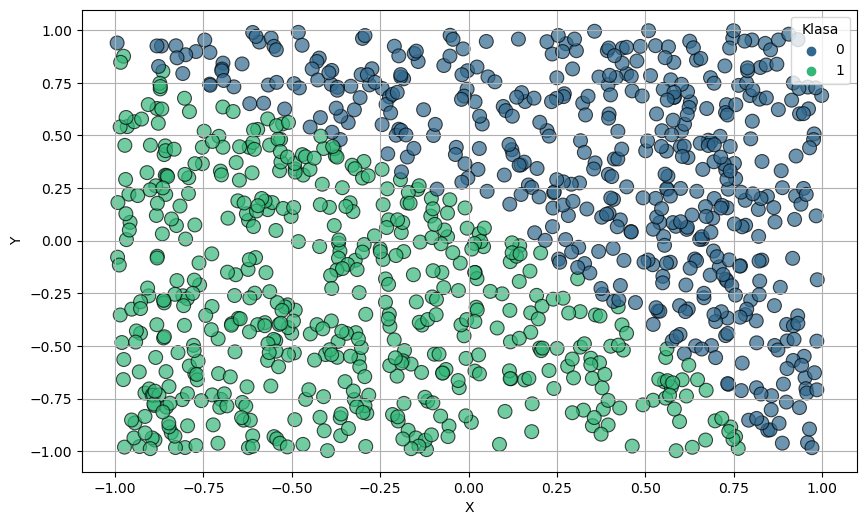

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
X_test = test_data[1:, 0]
Y_test = test_data[1:, 1]
C_test = test_data[1:, 2]

plt.figure(figsize=(10, 6))

Y_pred = [0 if net.predict_class(input) < 0.5 else 1 for input in test_data[1:, :2]]
sns.scatterplot(x=X_test, y=Y_test, hue=Y_pred, palette='viridis', s=100, edgecolor='k', alpha=0.7)


plt.xlabel('X')
plt.ylabel('Y')
plt.legend(title='Klasa')
plt.grid(True)

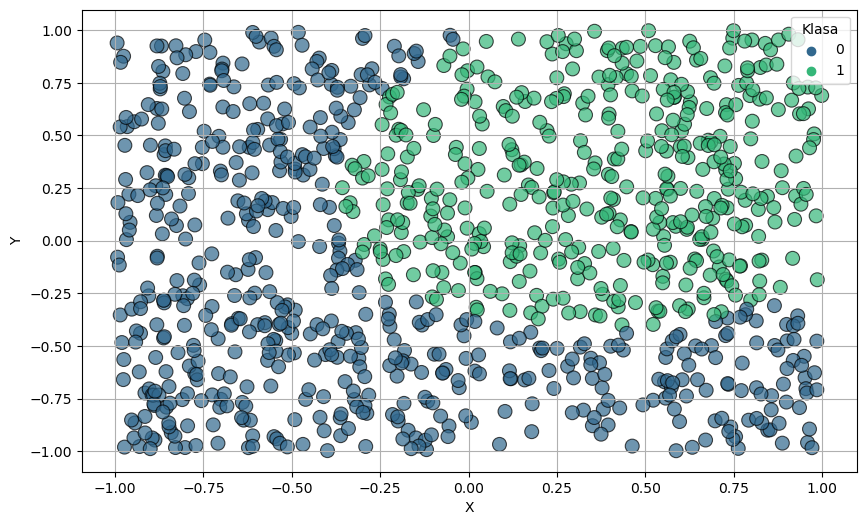

In [30]:
plt.figure(figsize=(10, 6))

Y_pred = [0 if net2.predict_class(input) < 0.31 else 1 for input in test_data[1:, :2]]
sns.scatterplot(x=X_test, y=Y_test, hue=Y_pred, palette='viridis', s=100, edgecolor='k', alpha=0.7)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend(title='Klasa')
plt.grid(True)

In [41]:
train_data = np.genfromtxt(
    "./projekt1/regression/data.activation.train.1000.csv", delimiter=","
)
test_data = np.genfromtxt(
    "./projekt1/regression/data.activation.test.1000.csv", delimiter=","
)
X_train = train_data[1:, 0]
Y_train = train_data[1:, 1]
X_test = test_data[1:, 0]
Y_test = test_data[1:, 1]
minx = min(X_train)
maxx = max(X_train)

net = NeuralNet(
    hidden_layers=3, number_of_neurons_in_layer=30, input_dim=1, activation_f="relu"
)
X_scaled = scale(X_train, minx, maxx)
X_test_scaled = scale(X_test, minx, maxx)
net.train_regre(X_scaled, Y_train, learning_rate=0.0001, epochs=1000, print_logs=True,  error_measure_type = 1)

print(f"RMSE on train data {evaluate_model_regre(net, X_scaled, Y_train)}")
print(f"RMSE on test data {evaluate_model_regre(net, X_test_scaled, Y_test)}")

Epoch: 0, mean loss: 11306.865320462282
Epoch: 1, mean loss: 14148.753410118929
Epoch: 2, mean loss: 13599.151215362384
Epoch: 3, mean loss: 15893.00702725912
Epoch: 4, mean loss: 15437.430167388753
Epoch: 5, mean loss: 14257.950716308493
Epoch: 6, mean loss: 15131.613700341164
Epoch: 7, mean loss: 11664.606199259455
Epoch: 8, mean loss: 9140.047816139479
Epoch: 9, mean loss: 12667.906000550143
Epoch: 10, mean loss: 10504.252979932031
Epoch: 11, mean loss: 8707.162322085314
Epoch: 12, mean loss: 6366.6420711997
Epoch: 13, mean loss: 9226.832616495543
Epoch: 14, mean loss: 8183.194054233859
Epoch: 15, mean loss: 8375.539515230163
Epoch: 16, mean loss: 8573.122013976381
Epoch: 17, mean loss: 8914.353601866042
Epoch: 18, mean loss: 5831.123501319749
Epoch: 19, mean loss: 7824.544288556477
Epoch: 20, mean loss: 5184.837978393996
Epoch: 21, mean loss: 8147.191055044923
Epoch: 22, mean loss: 7233.398061234035
Epoch: 23, mean loss: 7244.434480805752
Epoch: 24, mean loss: 7975.948901783312
Epo

Epoch: 202, mean loss: 55.21723346816036
Epoch: 203, mean loss: 45.82239514272298
Epoch: 204, mean loss: 41.40269463091482
Epoch: 205, mean loss: 40.332062440864576
Epoch: 206, mean loss: 49.441352651480585
Epoch: 207, mean loss: 45.425139881004114
Epoch: 208, mean loss: 49.606515029497274
Epoch: 209, mean loss: 35.08500626605868
Epoch: 210, mean loss: 32.90135888051619
Epoch: 211, mean loss: 37.75774792559948
Epoch: 212, mean loss: 41.969359154011364
Epoch: 213, mean loss: 35.845194816815244
Epoch: 214, mean loss: 32.737458856998416
Epoch: 215, mean loss: 37.201089598281584
Epoch: 216, mean loss: 39.88176316941077
Epoch: 217, mean loss: 35.38145423630201
Epoch: 218, mean loss: 33.2398028069398
Epoch: 219, mean loss: 32.327583457079
Epoch: 220, mean loss: 32.18969614190553
Epoch: 221, mean loss: 28.547901482925752
Epoch: 222, mean loss: 26.892549554410007
Epoch: 223, mean loss: 29.078331311432493
Epoch: 224, mean loss: 39.23387984156891
Epoch: 225, mean loss: 24.198410837951222
Epoch: 

Epoch: 399, mean loss: 13.316533741253862
Epoch: 400, mean loss: 16.529648224840464
Epoch: 401, mean loss: 14.44829341165849
Epoch: 402, mean loss: 12.837402962980201
Epoch: 403, mean loss: 14.496304400105057
Epoch: 404, mean loss: 14.691667910110716
Epoch: 405, mean loss: 16.176915414772353
Epoch: 406, mean loss: 17.996963325914177
Epoch: 407, mean loss: 16.000548562937933
Epoch: 408, mean loss: 13.986381020506858
Epoch: 409, mean loss: 16.32990010394565
Epoch: 410, mean loss: 13.8791175242486
Epoch: 411, mean loss: 12.638429815072591
Epoch: 412, mean loss: 13.089951136676804
Epoch: 413, mean loss: 15.858725440615094
Epoch: 414, mean loss: 13.785830353841384
Epoch: 415, mean loss: 13.674428974977795
Epoch: 416, mean loss: 15.845390515960148
Epoch: 417, mean loss: 12.899819145767403
Epoch: 418, mean loss: 15.282425295845613
Epoch: 419, mean loss: 18.109236673046773
Epoch: 420, mean loss: 20.078482610736145
Epoch: 421, mean loss: 15.137511731720549
Epoch: 422, mean loss: 14.146102343431

Epoch: 597, mean loss: 10.40929438706856
Epoch: 598, mean loss: 13.062276904458743
Epoch: 599, mean loss: 10.509885333822018
Epoch: 600, mean loss: 14.1071328020013
Epoch: 601, mean loss: 13.950727840412418
Epoch: 602, mean loss: 8.515641171264791
Epoch: 603, mean loss: 10.487271637771341
Epoch: 604, mean loss: 9.561021938869153
Epoch: 605, mean loss: 13.015861061911144
Epoch: 606, mean loss: 13.656216159524297
Epoch: 607, mean loss: 10.729960917875736
Epoch: 608, mean loss: 11.9732035149108
Epoch: 609, mean loss: 10.565704670578075
Epoch: 610, mean loss: 12.695896495924305
Epoch: 611, mean loss: 11.275262755974278
Epoch: 612, mean loss: 12.571684636408174
Epoch: 613, mean loss: 11.427337109878119
Epoch: 614, mean loss: 11.806027346870843
Epoch: 615, mean loss: 13.283442147306154
Epoch: 616, mean loss: 11.66145963628028
Epoch: 617, mean loss: 12.263279893454765
Epoch: 618, mean loss: 11.09725784263963
Epoch: 619, mean loss: 8.815684698611857
Epoch: 620, mean loss: 11.65461473068902
Epo

Epoch: 796, mean loss: 8.050208909692719
Epoch: 797, mean loss: 9.169404188401629
Epoch: 798, mean loss: 9.08868383195598
Epoch: 799, mean loss: 10.35998597781532
Epoch: 800, mean loss: 8.677488841375766
Epoch: 801, mean loss: 8.341301115314971
Epoch: 802, mean loss: 8.682554361784485
Epoch: 803, mean loss: 7.999745772730766
Epoch: 804, mean loss: 9.00445162912543
Epoch: 805, mean loss: 9.998643329555435
Epoch: 806, mean loss: 9.85236990240627
Epoch: 807, mean loss: 9.428920227905289
Epoch: 808, mean loss: 6.608271589827499
Epoch: 809, mean loss: 7.543995041452233
Epoch: 810, mean loss: 9.57969361222475
Epoch: 811, mean loss: 7.266938947748796
Epoch: 812, mean loss: 6.493102229499585
Epoch: 813, mean loss: 8.405774760825377
Epoch: 814, mean loss: 12.155103619216943
Epoch: 815, mean loss: 8.98211881422296
Epoch: 816, mean loss: 9.409308392469526
Epoch: 817, mean loss: 7.784935843289354
Epoch: 818, mean loss: 8.636827371917821
Epoch: 819, mean loss: 8.214697298748977
Epoch: 820, mean los

Epoch: 997, mean loss: 8.087625309780144
Epoch: 998, mean loss: 7.972686277564044
Epoch: 999, mean loss: 6.47833718444815
RMSE on train data 2.7391917747278893
RMSE on test data 25.22742404962825


In [46]:
net2 = NeuralNet(
    hidden_layers=3, number_of_neurons_in_layer=30, input_dim=1, activation_f="relu"
)

net2.train_regre(X_scaled, Y_train, learning_rate=0.0001, epochs=1000, print_logs=True, error_measure_type = 2)

print(f"RMSE on train data {evaluate_model_regre(net2, X_scaled, Y_train)}")
print(f"RMSE on test data {evaluate_model_regre(net2, X_test_scaled, Y_test)}")

Epoch: 0, mean loss: 67.74299231962924
Epoch: 1, mean loss: 81.02533527672122
Epoch: 2, mean loss: 84.88548426948282
Epoch: 3, mean loss: 102.28505998308498
Epoch: 4, mean loss: 100.86939607149252
Epoch: 5, mean loss: 101.19470787129313
Epoch: 6, mean loss: 106.03682633637733
Epoch: 7, mean loss: 98.43662865888147
Epoch: 8, mean loss: 69.87162464369516
Epoch: 9, mean loss: 108.67574417900016
Epoch: 10, mean loss: 89.47589911233919
Epoch: 11, mean loss: 76.15134757119348
Epoch: 12, mean loss: 73.8972984145995
Epoch: 13, mean loss: 95.31671890468853
Epoch: 14, mean loss: 89.9695079451411
Epoch: 15, mean loss: 90.9272535284397
Epoch: 16, mean loss: 91.41295330133991
Epoch: 17, mean loss: 89.54272248546364
Epoch: 18, mean loss: 75.52859981625926
Epoch: 19, mean loss: 98.63810565032719
Epoch: 20, mean loss: 49.80654136383632
Epoch: 21, mean loss: 97.80330297267342
Epoch: 22, mean loss: 92.23555580759975
Epoch: 23, mean loss: 86.73358346503743
Epoch: 24, mean loss: 94.22376185126393
Epoch: 2

Epoch: 205, mean loss: 86.03448777524058
Epoch: 206, mean loss: 89.19876723640346
Epoch: 207, mean loss: 67.46154322337284
Epoch: 208, mean loss: 98.86718345248644
Epoch: 209, mean loss: 99.6736966574824
Epoch: 210, mean loss: 79.6006292217065
Epoch: 211, mean loss: 82.91727621567266
Epoch: 212, mean loss: 108.30543738344153
Epoch: 213, mean loss: 94.99041633656158
Epoch: 214, mean loss: 95.47934191992849
Epoch: 215, mean loss: 102.58260635909443
Epoch: 216, mean loss: 94.35020686513035
Epoch: 217, mean loss: 68.05003123007839
Epoch: 218, mean loss: 75.95760149530182
Epoch: 219, mean loss: 90.4884835178185
Epoch: 220, mean loss: 86.51121432829159
Epoch: 221, mean loss: 77.0996733559063
Epoch: 222, mean loss: 102.83085906180128
Epoch: 223, mean loss: 107.53418314813935
Epoch: 224, mean loss: 88.001103812533
Epoch: 225, mean loss: 96.30675513144611
Epoch: 226, mean loss: 105.11880133655968
Epoch: 227, mean loss: 95.99404573030883
Epoch: 228, mean loss: 98.25512049689715
Epoch: 229, mean 

Epoch: 405, mean loss: 100.4921177867826
Epoch: 406, mean loss: 107.89220994006715
Epoch: 407, mean loss: 91.00549988762921
Epoch: 408, mean loss: 87.67286032151065
Epoch: 409, mean loss: 88.90213772043971
Epoch: 410, mean loss: 88.66502817462747
Epoch: 411, mean loss: 96.82586801571082
Epoch: 412, mean loss: 96.52662452632835
Epoch: 413, mean loss: 77.68311033091987
Epoch: 414, mean loss: 101.18190225528548
Epoch: 415, mean loss: 86.55867462850614
Epoch: 416, mean loss: 95.28144146344465
Epoch: 417, mean loss: 78.96788805201268
Epoch: 418, mean loss: 108.33002602712556
Epoch: 419, mean loss: 95.99871498316323
Epoch: 420, mean loss: 99.1864237589625
Epoch: 421, mean loss: 70.55009262178916
Epoch: 422, mean loss: 105.9114892759158
Epoch: 423, mean loss: 85.02001922508349
Epoch: 424, mean loss: 90.6518803625343
Epoch: 425, mean loss: 96.60492174979785
Epoch: 426, mean loss: 92.67858965198678
Epoch: 427, mean loss: 88.50784419303963
Epoch: 428, mean loss: 86.91809558465445
Epoch: 429, mea

Epoch: 606, mean loss: 82.225766744148
Epoch: 607, mean loss: 90.23028662783975
Epoch: 608, mean loss: 85.82287814438682
Epoch: 609, mean loss: 69.06038916538931
Epoch: 610, mean loss: 73.90218243633153
Epoch: 611, mean loss: 88.86369006411054
Epoch: 612, mean loss: 86.43240053298048
Epoch: 613, mean loss: 77.86597855994648
Epoch: 614, mean loss: 78.09784444598104
Epoch: 615, mean loss: 78.6292709195698
Epoch: 616, mean loss: 90.36985138373645
Epoch: 617, mean loss: 98.83690240279962
Epoch: 618, mean loss: 87.37627971897217
Epoch: 619, mean loss: 94.63220824101217
Epoch: 620, mean loss: 88.9486722657233
Epoch: 621, mean loss: 55.8736988536259
Epoch: 622, mean loss: 85.89182921696718
Epoch: 623, mean loss: 99.54775500398102
Epoch: 624, mean loss: 87.97476544070118
Epoch: 625, mean loss: 67.23822228910412
Epoch: 626, mean loss: 82.543374852583
Epoch: 627, mean loss: 95.35765050440511
Epoch: 628, mean loss: 100.765503421058
Epoch: 629, mean loss: 60.506355773387675
Epoch: 630, mean loss: 

Epoch: 808, mean loss: 70.11531736730048
Epoch: 809, mean loss: 88.2228018969352
Epoch: 810, mean loss: 73.22853722057825
Epoch: 811, mean loss: 93.9054687091795
Epoch: 812, mean loss: 86.80702057541856
Epoch: 813, mean loss: 95.80169380309378
Epoch: 814, mean loss: 72.01216212152642
Epoch: 815, mean loss: 92.457410242451
Epoch: 816, mean loss: 92.65575751834507
Epoch: 817, mean loss: 71.78507618855723
Epoch: 818, mean loss: 86.73324284639503
Epoch: 819, mean loss: 65.6444158504446
Epoch: 820, mean loss: 111.22604713174951
Epoch: 821, mean loss: 82.05408998410454
Epoch: 822, mean loss: 80.30686648711394
Epoch: 823, mean loss: 106.81562619867799
Epoch: 824, mean loss: 66.89652634252641
Epoch: 825, mean loss: 95.65164094814186
Epoch: 826, mean loss: 76.78708192233783
Epoch: 827, mean loss: 70.59672845466518
Epoch: 828, mean loss: 80.15539022613261
Epoch: 829, mean loss: 97.51964280259922
Epoch: 830, mean loss: 94.89282118944247
Epoch: 831, mean loss: 79.31014154083395
Epoch: 832, mean lo

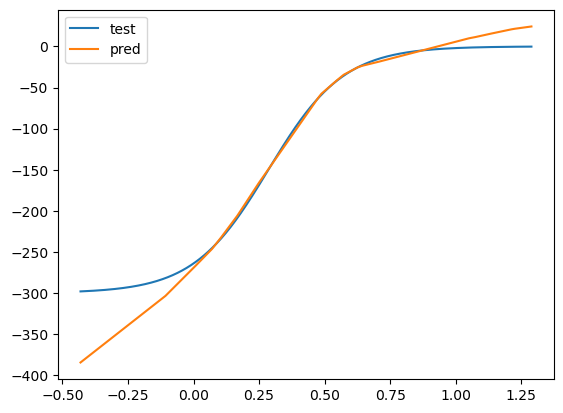

In [45]:
import matplotlib.pyplot as plt
plt.plot(X_test_scaled, Y_test, label = 'test')
Y_pred = [net.predict_regre(x) for x in X_test_scaled]
plt.plot(X_test_scaled, Y_pred, label = 'pred')
plt.legend()

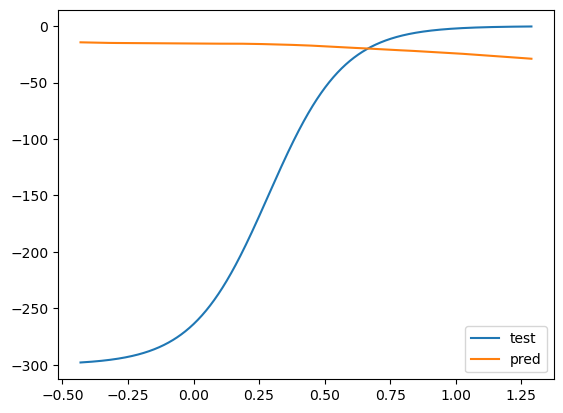

In [47]:
plt.plot(X_test_scaled, Y_test, label = 'test')
Y_pred = [net2.predict_regre(x) for x in X_test_scaled]
plt.plot(X_test_scaled, Y_pred, label = 'pred')
plt.legend()